In [1]:
!python -m pip install mpi4py

/usr/bin/python: No module named pip


In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
arr = 6.3 * np.random.randn(10) + 4.5
arr

array([ 0.52602036,  8.27857044,  0.78659305, -3.91709477, 16.70588057,
       -5.64212971,  6.75012938,  5.40650442, -4.68116583, -1.73650602])

In [4]:
def seqBubbleSort(arr):
  
  for i in range(len(arr)):
    
    for j in range(i+1, len(arr)):
      
      if arr[i] > arr[j]:
        arr[i], arr[j] = arr[j], arr[i]
  
  return arr

In [5]:
seqBubbleSort(arr)

array([-5.64212971, -4.68116583, -3.91709477, -1.73650602,  0.52602036,
        0.78659305,  5.40650442,  6.75012938,  8.27857044, 16.70588057])

In [6]:
import timeit

timeit.timeit(setup="from __main__ import seqBubbleSort, arr", stmt='seqBubbleSort(arr)', number=100)

0.0024630249999972875

In [7]:
seq_times = []
seq_sizes = []

for n in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
  
  arr = 6.3 * np.random.randn(n) + 4.5

  tt = timeit.timeit(setup="from __main__ import seqBubbleSort, arr", stmt='seqBubbleSort(arr)', number=100)
  
  seq_times.append(tt)
  seq_sizes.append(n)

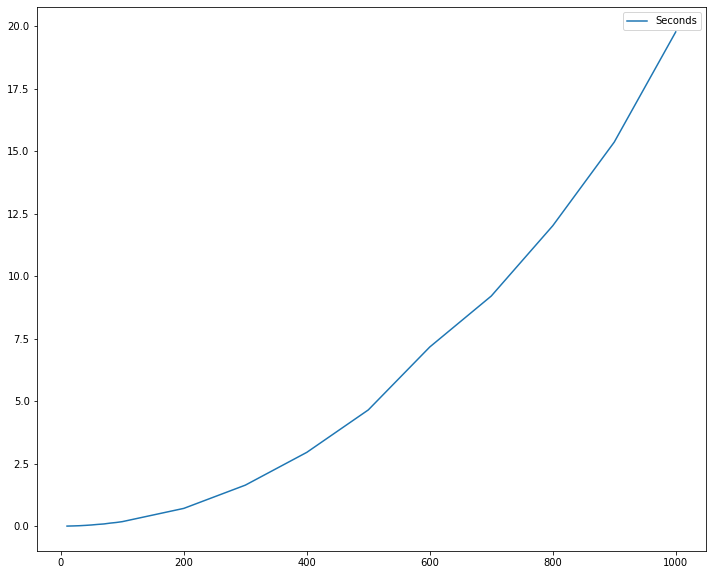

In [8]:
fig = plt.figure(figsize=(12, 10))
plt.plot(seq_sizes, seq_times, label='Seconds')
plt.legend()
plt.show();

In [9]:
def parallelBubbleSort(arr):

  n = len(arr)
  for k in range(n-1):
    if k % 2 == 0:
      for i in range(n//2 - 0):
        if arr[2*i] > arr[2*i+1]:
          arr[2*i], arr[2*i+1] = arr[2*i+1], arr[2*i]
    else:
      for i in range(n//2 - 1):
        if arr[2*i+1] > arr[2*i+2]:
          arr[2*i+1], arr[2*i+2] = arr[2*i+2], arr[2*i+1]

  return arr

arr = 6.3 * np.random.randn(10) + 4.5
parallelBubbleSort(arr)

array([-3.50455179, -3.26643758, -3.01371685, -2.78914764,  2.45969764,
        2.64834051,  2.75423263,  7.04835994, 11.28758499, 16.42655643])

In [10]:
import multiprocessing as mp
import numpy as np
from functools import partial


num_cores = mp.cpu_count()

arr = np.random.randint(low=-100, high=100, size=10)
mem_mgr = mp.Manager()
shared_arr = mem_mgr.list(arr)

def processEven(i):
  global shared_arr
  if shared_arr[2*i] > shared_arr[2*i+1]:
    shared_arr[2*i], shared_arr[2*i+1] = shared_arr[2*i+1], shared_arr[2*i]


def processOdd(i):
  global shared_arr
  if shared_arr[2*i+1] > shared_arr[2*i+2]:
    shared_arr[2*i+1], shared_arr[2*i+2] = shared_arr[2*i+2], shared_arr[2*i+1]

def mpBubbleSortAux(t, k):
    if k % 2 == 0:
      for i in range(t):
        processEven(i)
    else:
      for i in range(t - 1):
        processOdd(i)

def mpBubbleSortV1(n, p):
  for k in range(n):
    if k % 2 == 0:
      p.map(processEven, [i for i in range(n//2 - 0)])
    else:
      p.map(processOdd, [i for i in range(n//2 - 1)])

def mpBubbleSort(n, p):
    t = n//2
    func = partial(mpBubbleSortAux, t)
    p.imap(func, [k for k in range(n)])
    p.close()

p = mp.Pool(num_cores)
mpBubbleSort(len(arr), p)
p.close()
print('original array \t', arr)
print('sorted array \t', shared_arr)

original array 	 [  2  19   4  85 -55  48  56 -57  97  88]
sorted array 	 [2, 4, 4, 85, -55, 48, 56, -57, 97, 88]


In [11]:
seq_times = []
par_times = []
mp_times = []
sizes = []

for n in range(10, 501, 10):

  arr = 6.3 * np.random.randn(n) + 4.5
  mem_mgr = mp.Manager()
  shared_arr = mem_mgr.list(arr)
  p = mp.Pool(num_cores)

  tt_seq = timeit.timeit(setup="from __main__ import seqBubbleSort, arr", stmt='seqBubbleSort(arr)', number=1)
  tt_par = timeit.timeit(setup="from __main__ import parallelBubbleSort, arr", stmt='parallelBubbleSort(arr)', number=1)
  tt_mp = timeit.timeit(
      setup="from __main__ import mpBubbleSort, n, p", stmt='mpBubbleSort(n, p)', number=1)
  
  p.close()
    
  seq_times.append(tt_seq)
  par_times.append(tt_par)
  mp_times.append(tt_mp)
  sizes.append(n)


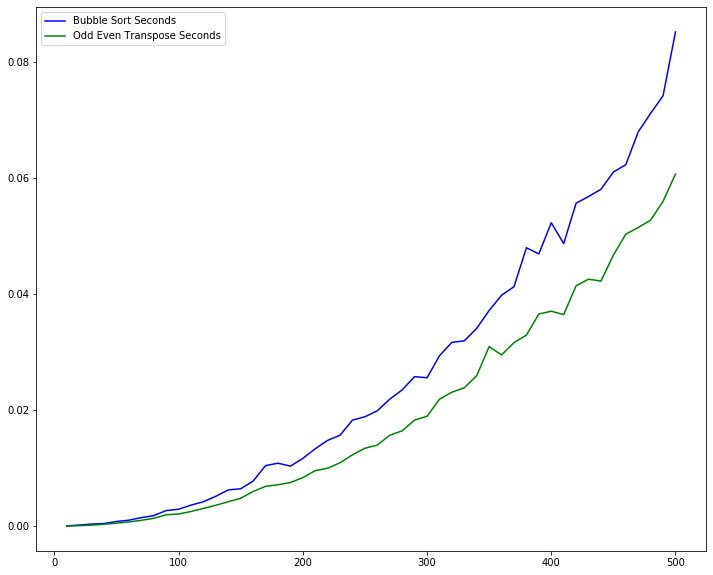

In [12]:
fig = plt.figure(figsize=(12, 10))
plt.plot(sizes, seq_times, label='Bubble Sort Seconds', c='b')
plt.plot(sizes, par_times, label='Odd Even Transpose Seconds', c='g')
plt.legend()
plt.show();

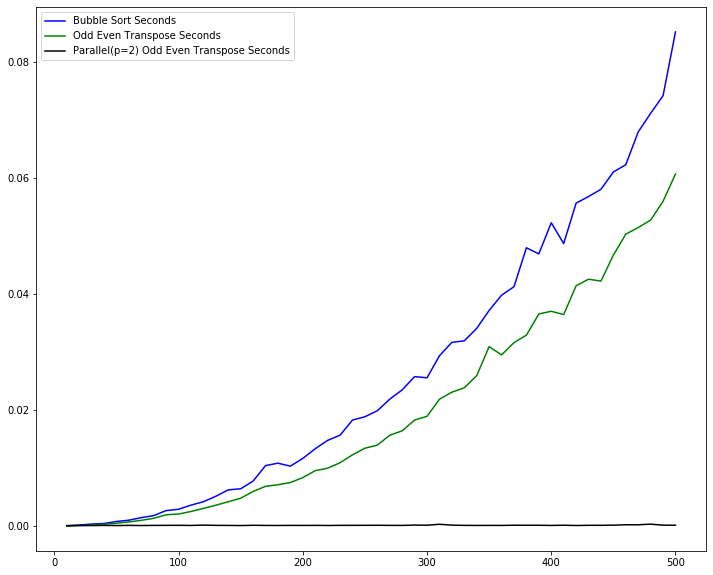

In [13]:
fig = plt.figure(figsize=(12, 10))
plt.plot(sizes, seq_times, label='Bubble Sort Seconds', c='b')
plt.plot(sizes, par_times, label='Odd Even Transpose Seconds', c='g')
plt.plot(sizes, mp_times, label='Parallel(p=2) Odd Even Transpose Seconds', c='k')
plt.legend()
plt.show();

In [14]:
avg = 0

for i, j in zip(seq_times, par_times):
  avg += abs(j - i) / j
 
avg = avg / len(seq_times)

print("Overall Improvement (Bubble Sort vs Odd-Even Transpose): %{:0.2f}".format(avg * 100))

Overall Improvement (Bubble Sort vs Odd-Even Transpose): %42.12


In [15]:
mp_4_times = []
mp_8_times = []
mp_10_times = []

sizes = []

for n in range(10, 501, 10):

  arr = 6.3 * np.random.randn(n) + 4.5
  mem_mgr = mp.Manager()
  shared_arr = mem_mgr.list(arr)
  p_4 = mp.Pool(4)
  p_8 = mp.Pool(8)
  p_10 = mp.Pool(16)

  tt_mp_4 = timeit.timeit(
      setup="from __main__ import mpBubbleSort, n, p_4", stmt='mpBubbleSort(n, p_4)', number=1
      )
  tt_mp_8 = timeit.timeit(
      setup="from __main__ import mpBubbleSort, n, p_8", stmt='mpBubbleSort(n, p_8)', number=1
      )
  tt_mp_10 = timeit.timeit(
      setup="from __main__ import mpBubbleSort, n, p_10", stmt='mpBubbleSort(n, p_10)', number=1
      )

  p_4.close()
  p_8.close()
  p_10.close()

  mp_4_times.append(tt_mp_4)
  mp_8_times.append(tt_mp_8)
  mp_10_times.append(tt_mp_10)
  sizes.append(n)


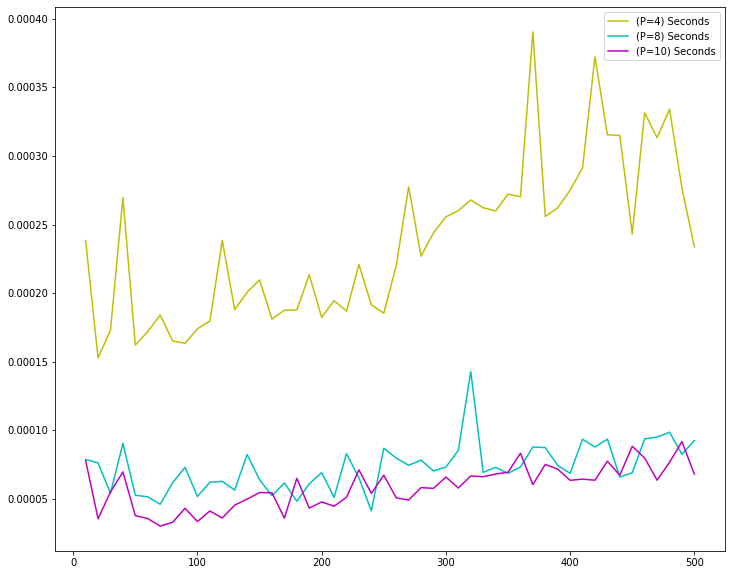

In [16]:
fig = plt.figure(figsize=(12, 10))
plt.plot(sizes, mp_4_times, label='(P=4) Seconds', c='y')
plt.plot(sizes, mp_8_times, label='(P=8) Seconds', c='c')
plt.plot(sizes, mp_10_times, label='(P=10) Seconds', c='m')
plt.legend()
plt.show();

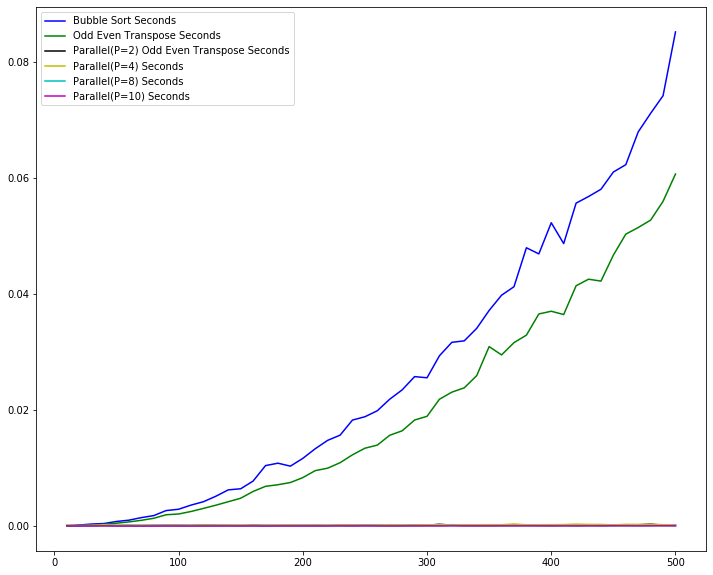

In [17]:
fig = plt.figure(figsize=(12, 10))
plt.plot(sizes, seq_times, label='Bubble Sort Seconds', c='b')
plt.plot(sizes, par_times, label='Odd Even Transpose Seconds', c='g')
plt.plot(sizes, mp_times, label='Parallel(P=2) Odd Even Transpose Seconds', c='k')
plt.plot(sizes, mp_4_times, label='Parallel(P=4) Seconds', c='y')
plt.plot(sizes, mp_8_times, label='Parallel(P=8) Seconds', c='c')
plt.plot(sizes, mp_10_times, label='Parallel(P=10) Seconds', c='m')
plt.legend()
plt.show();

**Hardware & Software Specifications**

In [18]:
!apt-get install -y hwinfo

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [19]:
!hwinfo

============ start debug info ============                      
libhd version 21.52u (x86-64) [7688]
using /var/lib/hardware
kernel version is 5.0
----- /proc/cmdline -----
  BOOT_IMAGE=/boot/vmlinuz-5.0.0-32-generic root=UUID=4e64727c-2bc3-42a6-b56b-817d126978bb ro quiet splash vt.handoff=1
----- /proc/cmdline end -----
debug = 0xff7ffff7
probe = 0x15938fcdaa17fcf9fffe (+memory +pci +isapnp +net +floppy +misc +misc.serial +misc.par +misc.floppy +serial +cpu +bios +monitor +mouse +scsi +usb -usb.mods +modem +modem.usb +parallel +parallel.lp +parallel.zip -isa -isa.isdn +isdn +kbd +prom +sbus +int +braille +braille.alva +braille.fhp +braille.ht -ignx11 +sys -bios.vbe -isapnp.old -isapnp.new -isapnp.mod +braille.baum -manual +fb +pppoe -scan +pcmcia +fork -parallel.imm +s390 +cpuemu -sysfs -s390disks +udev +block +block.cdrom +block.part +edd +edd.mod -bios.ddc -bios.fb -bios.mode +input +block.mods +bios.vesa -cpuemu.debug -scsi.noserial +wlan -bios.crc -hal +bios.vram +bios.acpi -bios

  Model: "Partition"
  Device File: /dev/sda1
  Device Files: /dev/sda1, /dev/disk/by-id/ata-ST9160412ASG_5VG4XSY7-part1, /dev/disk/by-id/wwn-0x5000c50024b0925f-part1, /dev/disk/by-partlabel/EFI\x20System\x20Partition, /dev/disk/by-partuuid/eb66125e-64e1-446d-b0cf-18c015a2b53a, /dev/disk/by-path/pci-0000:00:1f.2-ata-1-part1, /dev/disk/by-uuid/E6C7-2429
  Config Status: cfg=new, avail=yes, need=no, active=unknown
  Attached to: #60 (Disk)

62: None 00.0: 11300 Partition
  [Created at block.434]
  Unique ID: 2pkM.SE1wIdpsiiC
  Parent ID: 3OOL.OtJ4zcdrRs1
  SysFS ID: /class/block/sda/sda2
  Hardware Class: partition
  Model: "Partition"
  Device File: /dev/sda2
  Device Files: /dev/sda2, /dev/disk/by-id/ata-ST9160412ASG_5VG4XSY7-part2, /dev/disk/by-id/wwn-0x5000c50024b0925f-part2, /dev/disk/by-partuuid/1ad45544-97db-408c-9051-3eaeb1d34e08, /dev/disk/by-path/pci-0000:00:1f.2-ata-1-part2, /dev/disk/by-uuid/4e64727c-2bc3-42a6-b56b-817d126978bb
  Config Status: cfg=new, avail=yes, need=no, ac

In [20]:
!python3 -V

Python 3.6.8


In [21]:
!pip freeze

absl-py==0.7.1
alembic==1.1.0
apturl==0.5.2
asn1crypto==0.24.0
atari-py==0.2.6
attrs==19.1.0
backcall==0.1.0
bcolz==0.12.1
bleach==3.1.0
Bottleneck==1.2.1
Brlapi==0.6.6
certifi==2019.6.16
chardet==3.0.4
Click==7.0
cloudpickle==1.2.2
command-not-found==0.3
contextlib2==0.5.5
cryptography==2.1.4
cupshelpers==1.0
cycler==0.10.0
cyordereddict==1.0.0
Cython==0.29.13
decorator==4.4.0
defer==1.0.6
defusedxml==0.6.0
distro-info===0.18ubuntu0.18.04.1
empyrical==0.5.3
entrypoints==0.3
future==0.17.1
gpg==1.10.0
graphviz==0.11.1
grpcio==1.22.0
gym==0.14.0
hiddenlayer==0.2
html5lib==0.999999999
httplib2==0.9.2
idna==2.8
imageio==2.5.0
imutils==0.5.2
intervaltree==3.0.2
ipykernel==5.1.2
ipython==7.7.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.14.1
Jinja2==2.10.1
joblib==0.13.2
jsonschema==3.0.2
jupyter==1.0.0
jupyter-client==5.3.1
jupyter-console==6.0.0
jupyter-core==4.5.0
keyring==10.6.0
keyrings.alt==3.0
kiwisolver==1.1.0
language-selector==0.1
launchpadlib==1.10.6
lazr.restfulclient==0.1